# <Span style = 'color: #008B8B'> Data Exploration

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
#NLP library 
import re
import unicodedata
import nltk
from wordcloud import WordCloud

#My libraries 
import acquire as a 
from env import user, password, hostname


#Beautiful Soup and Webscrape
from requests import get
from bs4 import BeautifulSoup


## <Span style = 'color: #008B8B'>ACQUIRE 
### <span style = 'color: purple'>1.Spam Data

#### a. Load the spam data set.

In [2]:
def get_connection(db_name, host=hostname, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{hostname}/{db_name}'


url = get_connection("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## <Span style = 'color: #008B8B'> PREPARE

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
#Example of text
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [6]:
#Ham vs Spam

labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
# Ham vs Spam function
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


Break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.


In [8]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


## <Span style = 'color: #008B8B'> EXPLORE SPAM DATA

#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
Is there any overlap in the bigrams for the spam data and the ham data?

In [9]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [10]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()



(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

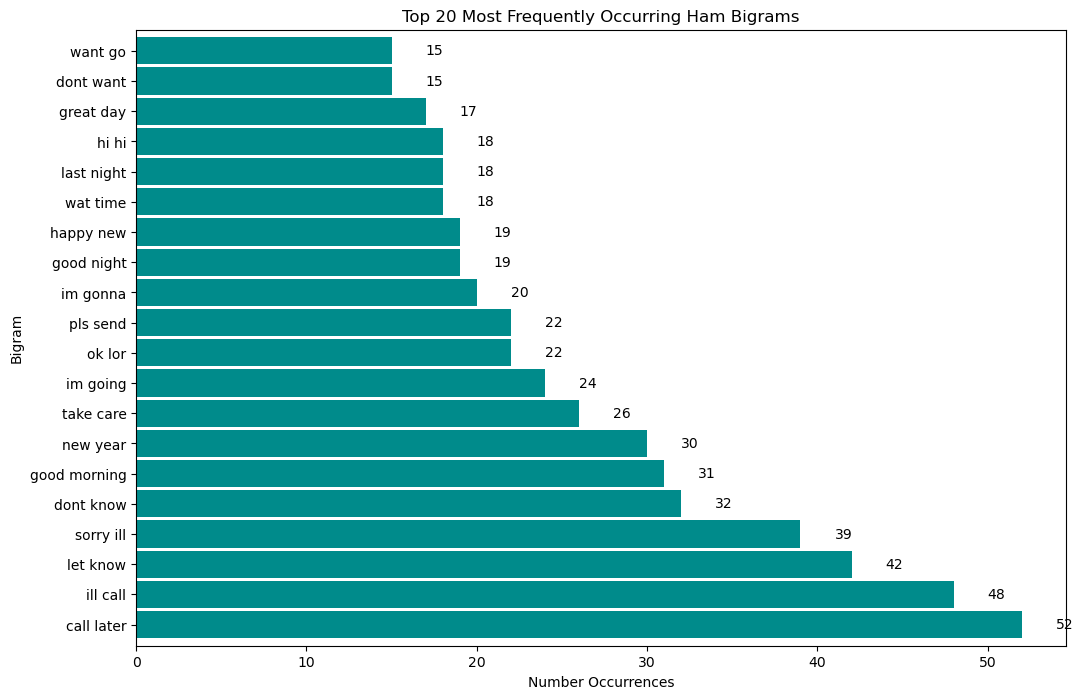

In [13]:
# Sort the bigrams in descending order by frequency
top_20_ham_bigrams = top_20_ham_bigrams.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
bars = top_20_ham_bigrams.plot(kind='barh', color = '#008B8B', width=0.9)

# Add count annotations at the end of the bars
for bar in bars.patches:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=10, color='black')

plt.title('Top 20 Most Frequently Occurring Ham Bigrams')
plt.xlabel('Number Occurrences')
plt.ylabel('Bigram')

# Make the labels pretty
ticks, labels = plt.yticks()
new_labels = [f'{bigram[0]} {bigram[1]}' for bigram in top_20_ham_bigrams.index]
plt.yticks(ticks, new_labels)

plt.show()


#### BIGRAM WORD CLOUD

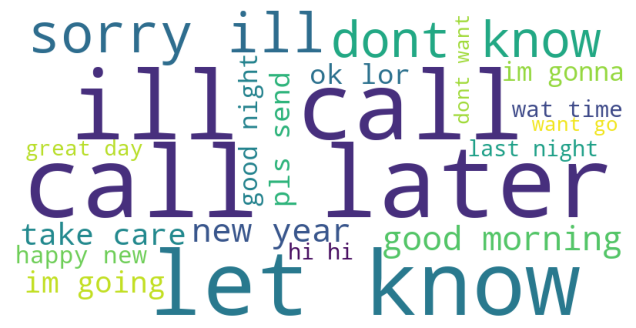

In [22]:

data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


### The barplot and word cloud are similar. Showing 'call later','ill call' and 'let know' as the most frequent

# <Span style = 'color: #008B8B'> CODEUP BLOG 

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [31]:
url = 'https://codeup.edu/blog/'
headers = {'User-Agent': 'Codeup Data Science'}
response = get(url, headers=headers)

soup = BeautifulSoup(response.content, 'html.parser')

links = [link['href'] for link in soup.select('.more-link')]

articles = []

for url in links:
    
    url_response = get(url, headers=headers)
    soup = BeautifulSoup(url_response.text)
    
    title = soup.find('h1', class_='entry-title').text
    content = soup.find('div', class_='entry-content').text.strip()
    
    article_dict = {
        'title': title,
        'content': content
    }
    
    articles.append(article_dict)

In [39]:
blog_df = pd.DataFrame(articles)
blog_df

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...
5,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...


In [40]:
blog_df.to_csv('blog_articles.csv', index=False)

In [41]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean_blog(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [45]:

blog_df['cleaned_content'] = blog_df['content'].apply(clean_blog)


In [46]:
#Value counts of labels
blog_df['title'].value_counts()

Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa    1
Women in tech: Panelist Spotlight – Magdalena Rahn                                        1
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill                                1
Women in Tech: Panelist Spotlight – Sarah Mellor                                          1
Women in Tech: Panelist Spotlight – Madeleine Capper                                      1
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia                  1
Name: title, dtype: int64

In [54]:

#Ham vs Spam for title

title_labels = pd.concat([blog_df.title.value_counts(),
                    blog_df.title.value_counts(normalize=True)], axis=1)
title_labels.columns = ['n', 'percent']
title_labels

,n,percent
Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa,1,0.166667
Women in tech: Panelist Spotlight – Magdalena Rahn,1,0.166667
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill,1,0.166667
Women in Tech: Panelist Spotlight – Sarah Mellor,1,0.166667
Women in Tech: Panelist Spotlight – Madeleine Capper,1,0.166667
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia,1,0.166667


In [55]:

#Ham vs Spam for content

labels = pd.concat([blog_df.content.value_counts(),
                    blog_df.content.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

n   percent
May is traditionally known as Asian American an...  1  0.166667
Women in tech: Panelist Spotlight – Magdalena R...  1  0.166667
Women in tech: Panelist Spotlight – Rachel Robb...  1  0.166667
Women in tech: Panelist Spotlight – Sarah Mello...  1  0.166667
Women in tech: Panelist Spotlight – Madeleine C...  1  0.166667
Black excellence in tech: Panelist Spotlight – ...  1  0.166667

In [58]:
ham_words = clean(' '.join(blog_df[df.label == 'ham'].content))
spam_words = clean(' '.join(blog_df[df.label == 'spam'].content))
all_words = clean(' '.join(blog_df.content))

/var/folders/0f/gkm6knzn3fscjt7dxlgc9k5h0000gn/T/ipykernel_86061/1176668448.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ham_words = clean(' '.join(blog_df[df.label == 'ham'].content))
/var/folders/0f/gkm6knzn3fscjt7dxlgc9k5h0000gn/T/ipykernel_86061/1176668448.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spam_words = clean(' '.join(blog_df[df.label == 'spam'].content))


### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.